<a href="https://colab.research.google.com/github/LucasNH/CSC413-Final-Project/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import files
# files.upload() # Upload your kaggle API Key

In [ ]:
# Installing required packages
# !pip install arxiv
# !pip install -q kaggle

In [ ]:
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/

# !chmod 600 /root/.kaggle/kaggle.json

# # Create the directories for original data
# !rm -rf ./dataset/
# !kaggle datasets download -d Cornell-University/arxiv
# !unzip arxiv.zip > /dev/null

In [ ]:
# !ls -lah /content/

## Part 1

Download the files `reuters_train.txt` and `reuters_valid.txt`, and upload them to Google Drive.

Then, mount Google Drive from your Google Colab notebook:

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline

In [9]:
!pip install torchtext==0.6.0

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')


# train_path = '/content/gdrive/My Drive/Colab Notebooks/data/arxiv_train.txt'
# valid_path = '/content/gdrive/My Drive/Colab Notebooks/data/arxiv_valid.txt'

Mounted at /content/gdrive


In [7]:
file_path =  '/content/gdrive/MyDrive/Colab Notebooks/data/arxiv.txt'

We will be using PyTorch's `torchtext` utilities to help us load, process,
and batch the data. This package is useful, but takes a bit of time to get
used to.

We'll be using a `TabularDataset` to load our data, which works well on structured
CSV data with fixed columns (e.g. a column for the sequence, a column for the label). Our tabular dataset
is even simpler: we have no labels, just some text. So, we are treating our data as a table with one field
representing our sequence.

In [12]:
import torchtext

# Tokenization function to separate a headline into words
def tokenize_headline(headline):
    """Returns the sequence of words in the string headline. We also
    prepend the "<bos>" or beginning-of-string token, and append the
    "<eos>" or end-of-string token to the headline.
    """
    return ("<bos> " + headline + " <eos>").split()

# Data field (column) representing our *text*.

text_field = torchtext.data.Field(
    sequential=True,            # this field consists of a sequence
    tokenize=tokenize_headline, # how to split sequences into words
    include_lengths=True,       # to track the length of sequences, for batching
    batch_first=True,           # similar to batch_first=True in nn.RNN demonstrated in lecture
    use_vocab=True)             # to turn each character into an integer index

full_dataset = torchtext.data.TabularDataset(
    path=file_path,                 # data file path
    format="tsv",                   # fields are separated by a tab
    fields=[('title', text_field)]) # list of fields (we have only one)

# Split the dataset into train and validation sets (80/20 split)
train_data, val_data = full_dataset.split(split_ratio=0.8)

### Part (a) -- 2 points

Draw histograms of the number of words per headline in our training set.
Excluding the `<bos>` and `<eos>` tags in your computation.
Explain why we would be interested in such histograms.

['<bos>', 'Bosonic', 'characters', 'of', 'atomic', 'Cooper', 'pairs', 'across', 'resonance', '<eos>']
['<bos>', 'Calculation', 'of', 'prompt', 'diphoton', 'production', 'cross', 'sections', 'at', 'Tevatron', 'and', 'LHC', 'energies', '<eos>']


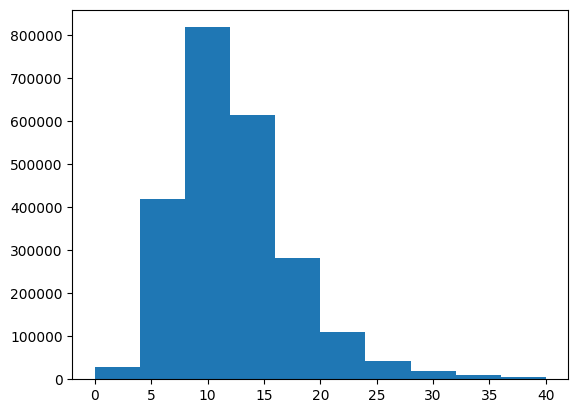

In [ ]:
# Include your histogram and your written explanations

# Here is an example of how to plot a histogram in matplotlib:
# plt.hist(np.random.normal(0, 1, 40), bins=)

word_counts = [len(x.title) - 2 for x in train_data] # Exclude <bos>, <eos>
plt.hist(word_counts, bins=10, range=(0, 40))

# Here are some sample code that uses the train_data object:
print(train_data[5].title)
for example in train_data:
    print(example.title)
    break

### Part (b) -- 2 points

How many distinct words appear in the training data?
Exclude the `<bos>` and `<eos>` tags in your computation.

In [14]:
# Report your values here. Make sure that you report the actual values,
# and not just the code used to get those values

# You might find the python class Counter from the collections package useful
from collections import Counter
words_cnt = Counter()
for x in train_data:
  words_cnt.update(x.title[1:-1])

print(f'Distinct Words: {len(words_cnt)}')

Distinct Words: 253578


### Part (c) -- 2 points

The distribution of *words* will have a long tail, meaning that there are some words
that will appear very often, and many words that will appear infrequently. How many words
appear exactly once in the training set? Exactly twice?

In [15]:
# Report your values here. Make sure that you report the actual values,
# and not just the code used to get those values


word_freqs = [(word, count) for (word, count) in words_cnt.items()]

appear_once = [word for (word, count) in word_freqs if count == 1]
appear_twice = [word for (word, count) in word_freqs if count == 2]

print(f"Appearing Once: {appear_once[:10]}")
print(f"Appearing Twice: {appear_twice[:10]}")



Appearing Once: ['SalSi', 'PanoVOS', 'LHRM', 'Pli', 'PyStokes', 'Grillakis', 'Machedon', 'Margetis', 'multibranching', 'J082053']
Appearing Twice: ['Multimodular', 'Finalized', 'Waldenfels', 'duopolies', '9PN', 'Deinterleaver', 'Hyponormality', 'temerature', 'CygnusX', 'THERMUS']


### Part (d) -- 2 points

Explain why we may wish to replace these infrequent
words with an `<unk>` tag, instead of learning embeddings for these rare words.
(Hint: Consider words in the validation set that might not appear in training)

In [ ]:
# Include your explanation here

# Words in the validation set that do not appear during training will not have have an associated embeddings.
# We can obtain an embedding for thses unseen words by substituting them with <unk>

### Part (e) -- 2 points

We will only model the top 9995 words in the training set, excluding the tags
`<bos>`, `<eos>`, and other possible tags we haven't mentioned yet
(including those, we will have a vocabulary size of exactly 10000 tokens).

What percentage of word occurrences will be supported? Alternatively, what percentage
of word occurrences in the training set will be set to the `<unk>` tag?

In [16]:
# Report your values here. Make sure that you report the actual values,
# and not just the code used to get those values

top_words = words_cnt.most_common(9995)
total = len(list(words_cnt.elements()))

total_kept = 0
for _, cnt in top_words:
  total_kept += cnt

print(f'Percentage of occurrences supported: {total_kept / total}')

Percentage of occurrences supported: 0.9182234230469967


Our `torchtext` package will help us keep track of our list of unique words, known
as a **vocabulary**. A vocabulary also assigns a unique integer index to each word.
You can interpret these indices as sparse representations of one-hot vectors.

In [17]:
# Build the vocabulary based on the training data. The vocabulary
# can have at most 9997 words (9995 words + the <bos> and <eos> token)
text_field.build_vocab(train_data, max_size=9997)

# This vocabulary object will be helpful for us
vocab = text_field.vocab
print(vocab.stoi["hello"]) # for instances, we can convert from string to (unique) index
print(vocab.itos[10])      # ... and from word index to string

# The size of our vocabulary is actually 10000
vocab_size = len(text_field.vocab.stoi)
print(vocab_size) # should be 10000


# The reason is that torchtext adds two more tokens for us:
print(vocab.itos[0]) # <unk> represents an unknown word not in our vocabulary
print(vocab.itos[1]) # <pad> will be used to pad short sequences for batching

0
$
10000
<unk>
<pad>


## Question 2

Building a text autoencoder is a little more complicated than an image autoencoder, so
we'll need to thoroughly understand the model that we want to build before actually building
our model. Note that the best and fastest way to complete this assignment is to spend a *lot*
of time upfront understanding the architecture. The explanations are quite dense, and you
might need to stop every sentence or two to understand what's going on.
You won't feel productive for a while since you won't be writing code,
but this initial investment will help you become more productive later on.
Understanding this architecture will also help you understand other machine learning
papers you might come across. So, take a deep breath, and let's do this!

Here is a diagram showing our desired architecture:

![](https://github.com/LucasNH/CSC413-Final-Project/blob/model-training/p4model.png?raw=1){ width=90% }

<img src="https://github.com/LucasNH/CSC413-Final-Project/blob/model-training/p4model.png?raw=1" width="95%" />

There are two main components to the model: the **encoder** and the **decoder**.
As always with neural networks, we'll first describe how to make
**predictions** with of these components. Let's get started:

The **encoder** will take a sequence of words (a headline) as *input*, and produce an
embedding (a vector) that represents the entire headline. In the diagram above,
the vector ${\bf h}^{(7)}$ is the vector embedding containing information about
the entire headline.  This portion is very similar
to the sentiment analysis RNN that we discussed in lecture (but without the fully-connected
layer that makes a prediction).

The **decoder** will take an embedding (in the diagram, the vector ${\bf h}^{(7)}$) as input,
and uses a separate RNN to **generate a sequence of words**. To generate a sequence of words,
the decoder needs to do the following:

1) Determine the previous word that was generated. This previous word will act as ${\bf x}^{(t)}$
   to our RNN, and will be used to update the hidden state ${\bf m}^{(t)}$. Since each of our
   sequences begin with the `<bos>` token, we'll set ${\bf x}^{(1)}$ to be the `<bos>` token.
2) Compute the updates to the hidden state ${\bf m}^{(t)}$ based on the previous hidden state
   ${\bf m}^{(t-1)}$ and ${\bf x}^{(t)}$. Intuitively, this hidden state vector ${\bf m}^{(t)}$
   is a representation of *all the words we still need to generate*.
3) We'll use a fully-connected layer to take a hidden state ${\bf m}^{(t)}$, and determine
   *what the next word should be*. This fully-connected layer solves a *classification problem*,
   since we are trying to choose a word out of $K=10000$ distinct words. As in a classification
   problem, the fully-connected neural network will compute a *probability distribution* over
   these 10,000 words. In the diagram, we are using ${\bf z}^{(t)}$ to represent the logits,
   or the pre-softmax activation values representing the probability distribution.
4) We will need to *sample* an actual word from this probability distribution ${\bf z}^{(t)}$.
   We can do this in a number of ways, which we'll discuss in question 3. For now, you can
   imagine your favourite way of picking a word given a distribution over words.
5) This word we choose will become the next input ${\bf x}^{(t+1)}$ to our RNN, which is used
   to update our hidden state ${\bf m}^{(t+1)}$---i.e. to determine what are the remaining
   words to be generated.

We can repeat this process until we see an `<eos>` token generated, or until the generated
sequence becomes too long.

Unfortunately, we can't *train* this autoencoder in the way we just described. That is,
we can't just compare our generated sequence with our ground-truth sequence, and get
gradients. Both sequences are **discrete** entities, so we won't be able to compute
gradients at all! In particular, **sampling is a discrete process**, and so we won't be
able to back-propagate through any kind of sampling that we do.

You might wonder whether we can get away with computing gradients by comparing the
distributions ${\bf z}^{(t)}$ with the ground truth words at each time step. Like any
multi-class classification problem, we can represent the ground-truth words as a one-hot
vector, and use the cross-entropy loss.

In theory, we can do this. In practice, there are a few issues. One is that the generated
sequence might be longer or shorter than the actual sequence, meaning that there may
be more/fewer ${\bf z}^{(t)}$s than ground-truth words. Another more insidious issue
is that the **gradients will become very high-variance and unstable**, because
**early mistakes will easily throw the model off-track**. Early in training,
our model is unlikely to produce the right answer in step $t=1$, so the gradients
we obtain based on the other time steps will not be very useful.

At this point, you might have some ideas about "hacks" we can use to make training
work. Fortunately, there is one very well-established solution called
**teacher forcing** which we can use for training:
instead of *sampling* the next word based on ${\bf z}^{(t)}$, we will forgo sampling,
and use the **ground truth** ${\bf x}^{(t)}$ in the next step.

Here is a diagram showing how we can use **teacher forcing** to train our model:

![](https://github.com/LucasNH/CSC413-Final-Project/blob/model-training/p4model_tf.png?raw=1){ width=90% }

<img src="https://github.com/LucasNH/CSC413-Final-Project/blob/model-training/p4model_tf.png?raw=1" width="95%" />

We will use the RNN generator to compute the logits
${\bf z}^{(1)},{\bf z}^{(2)},  \cdots {\bf z}^{(T)}$. These distributions
can be compared to the ground-truth words using the cross-entropy loss.
The loss function for this model will be the sum of the losses across each $t$.
(This is similar to what we did in a pixel-wise prediction problem.)

We'll train the encoder and decoder model simultaneously. There are several components
to our model that contain tunable weights:

- The word embedding that maps a word to a vector representation.
  In theory, we could use GloVe embeddings, or initialize our parameters to
  GloVe embeddings. To prevent students who don't have Colab access
  from having to download a 1GB file, we won't do that.
  The word embedding component is represented with blue arrows in the diagram.
- The encoder RNN (which will use Gated Recurrent Units) that computes the
  embedding over the entire headline. The encoder RNN
  is represented with black arrows in the diagram.
- The decoder RNN (which will also use Gated Recurrent Units) that computes
  hidden states, which are vectors representing what words are to be generated.
  The decoder RNN is represented with gray arrows in the diagram.
- The **projection MLP** (one fully-connected layer) that computes
  a distribution over the next word to generate, given a decoder RNN hidden
  state.


### Part (a) -- 10 pts

Complete the code for the AutoEncoder class below by:

1. Filling in the missing numbers in the `__init__` method using
   the parameters `vocab_size`, `emb_size`, and `hidden_size`. (4 points)
2. Complete the `forward` method, which uses teacher forcing
   and computes the logits $z^{(t)}$ of the reconstruction of
   the sequence. (4 points)

You should first try to understand the `encode` and `decode` methods,
which are written for you. The `encode` method mimics a discriminative
RNN (see the sentiment analysis notebook).  The `decode` method is
a generative RNN and is a bit more complex (see the text generation
tutorial notebook).  You might want to scroll down to the
`sample_sequence` function to see how this function will be called.

You can (but don't have to) use the `encode` and `decode` method in
your `forward` method. In either case, be very careful of the input
that you feed into ether `decode` or to `self.decoder_rnn`.
Refer to the teacher-forcing diagram.

In [18]:
class AutoEncoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size):
        """
        A text autoencoder. The parameters
            - vocab_size: number of unique words/tokens in the vocabulary
            - emb_size: size of the word embeddings $x^{(t)}$
            - hidden_size: size of the hidden states in both the
                           encoder RNN ($h^{(t)}$) and the
                           decoder RNN ($m^{(t)}$)
        """
        super().__init__()
        self.embed = nn.Embedding(num_embeddings=vocab_size, # TODO
                                  embedding_dim=emb_size)  # TODO
        self.encoder_rnn = nn.GRU(input_size=emb_size, #TODO
                                  hidden_size=hidden_size, #TODO
                                  batch_first=True)
        self.decoder_rnn = nn.GRU(input_size=emb_size, #TODO
                                  hidden_size=hidden_size, #TODO
                                  batch_first=True)
        self.proj = nn.Linear(in_features=hidden_size, # TODO
                              out_features=vocab_size) # TODO

    def encode(self, inp):
        """
        Computes the encoder output given a sequence of words.
        """
        emb = self.embed(inp)
        out, last_hidden = self.encoder_rnn(emb)
        return last_hidden

    def decode(self, inp, hidden=None):
        """
        Computes the decoder output given a sequence of words, and
        (optionally) an initial hidden state.
        """
        emb = self.embed(inp)
        out, last_hidden = self.decoder_rnn(emb, hidden)
        out_seq = self.proj(out)
        return out_seq, last_hidden

    def forward(self, inp):
        """
        Compute both the encoder and decoder forward pass
        given an integer input sequence inp with shape [batch_size, seq_length],
        with inp[a,b] representing the (index in our vocabulary of) the b-th word
        of the a-th training example.

        This function should return the logits $z^{(t)}$ in a tensor of shape
        [batch_size, seq_length - 1, vocab_size], computed using *teaching forcing*.

        The (seq_length - 1) part is not a typo. If you don't understand why
        we need to subtract 1, refer to the teacher-forcing diagram above.
        """

        last_hidden = self.encode(inp)
        # print(last_hidden.shape) # Should be [1, batch_size, hidden_size]

        # Why do we have L - 1 logits?
        # We do not pass the <eos> token to the Autoencoder, as there is no
        # "next word" to sample.

        out_seq, last_hidden = self.decode(inp, last_hidden)
        # print(out_seq.shape) # should be [batch_size, seq_length, vocab_size]

        return out_seq[:, :-1, :]

In [19]:
# Emulating the forward pass on a batch of examples

model = AutoEncoder(vocab_size, 128, 128)
# Load the dataset in batches of 100 examples
train_dataloader = torchtext.data.Iterator(train_data, 100,
                                           train=True, repeat=True,
                                           shuffle=True, device=None)

X = next(iter(train_dataloader)).title[0]
# print(X.shape)
last_hidden = model.encode(X)

print(last_hidden.shape) # Remove 1 in dim 0

out_seq, last_hidden = model.decode(X, last_hidden)
print(out_seq.shape)




torch.Size([1, 100, 128])
torch.Size([100, 61, 10000])


### Part (b) -- 5 pts

To check that your model is set up correctly, we'll train our AutoEncoder
neural network for at least 300 iterations to memorize this sequence:

We are looking for the way that you set up your loss function
corresponding to the figure above.
**Be very careful of off-by-ones.**

Note that the Cross Entropy Loss expects a rank-2 tensor as its first
argument, and a rank-1 tensor as its second argument. You will
need to properly reshape your data to be able to compute the loss.

In [ ]:
model = AutoEncoder(vocab_size, 128, 128)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

batch_stream = iter(train_dataloader)

for it in range(300):
    optimizer.zero_grad()
    # Get a batch of examples. The shape is [B, L]
    X = next(batch_stream).title[0]
    logits = model.forward(X) # output logits from the decoder [B, L - 1, vocab_size]
    logits = torch.permute(logits, (0, 2, 1)) # correct shape for loss fn is [B, vocab_size, L - 1]
    targets = X[:,1:] # Shape is [B, L - 1] (we don't generate the first token in the input sequence, <bos>)

    # TODO
    loss = criterion(logits, targets)
    loss.backward()
    optimizer.step()

    if (it+1) % 50 == 0:
        print("[Iter %d] Loss %f" % (it+1, float(loss)))

# Denoising Autoencoder


dd### Part (b) -- 2pt

We will add noise to our headlines using a few different techniques:

1. Shuffle the words in the headline, taking care that words don't end up too far from where they were initially
2. Drop (remove) some words
3. Replace some words with a blank word (a `<pad>` token)
4. Replace some words with a random word

The code for adding these types of noise is provided for you:


In [21]:
def tokenize_and_randomize(headline,
                           drop_prob=0.1,  # probability of dropping a word
                           blank_prob=0.1, # probability of "blanking" out a word
                           sub_prob=0.1,   # probability of substituting a word with a random one
                           shuffle_dist=3): # maximum distance to shuffle a word
    """
    Add 'noise' to a headline by slightly shuffling the word order,
    dropping some words, blanking out some words (replacing with the <pad> token)
    and substituting some words with random ones.
    """
    title = [vocab.stoi[w] for w in title.split()]
    n = len(title)
    # shuffle
    title = [title[i] for i in get_shuffle_index(n, shuffle_dist)]

    new_title = [vocab.stoi['<bos>']]
    for w in title:
        if random.random() < drop_prob:
            # drop the word
            pass
        elif random.random() < blank_prob:
            # replace with blank word
            new_title.append(vocab.stoi["<pad>"])
        elif random.random() < sub_prob:
            # substitute word with another word
            new_title.append(random.randint(0, vocab_size - 1))
        else:
            # keep the original word
            new_title.append(w)
    new_title.append(vocab.stoi['<eos>'])
    return new_title

def get_shuffle_index(n, max_shuffle_distance):
    """ This is a helper function used to shuffle a headline with n words,
    where each word is moved at most max_shuffle_distance. The function does
    the following:
       1. start with the *unshuffled* index of each word, which
          is just the values [0, 1, 2, ..., n]
       2. perturb these "index" values by a random floating-point value between
          [0, max_shuffle_distance]
       3. use the sorted position of these values as our new index
    """
    index = np.arange(n)
    perturbed_index = index + np.random.rand(n) * 3
    new_index = sorted(enumerate(perturbed_index), key=lambda x: x[1])
    return [index for (index, pert) in new_index]

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim

class DenoisAdversarialAutoencoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, lambda_param):
        super().__init__()

        # Encoder, Decoder, and Discriminator from the provided AutoEncoder class
        self.autoencoder = AutoEncoder(vocab_size, emb_size, hidden_size)

        # Discriminator network
        self.discriminator = nn.Sequential(
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

        self.lambda_param = lambda_param

    def encode(self, inp):
        return self.autoencoder.encode(inp)

    def decode(self, inp, hidden=None):
        return self.autoencoder.decode(inp, hidden)

    def forward(self, inp):
        return self.autoencoder(inp)

    def adversarial_loss(self, z_prior, z_encoder):

      real_labels = torch.ones_like(z_prior[:, :, :1])
      fake_labels = torch.zeros_like(z_encoder[:, :, :1])


      discriminator_linear = nn.Linear(1, 1)


      adv_loss = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for stability
      d_loss = adv_loss(discriminator_linear(z_prior[:, :, :1]), real_labels) + adv_loss(discriminator_linear(z_encoder[:, :, :1]), fake_labels)


      g_loss = adv_loss(discriminator_linear(z_encoder[:, :, :1]), real_labels)

      return d_loss, self.lambda_param * g_loss



    def train_step(self, inp):

        z_encoder = self.encode(inp)
        z_prior = torch.randn_like(z_encoder)


        d_loss, g_loss = self.adversarial_loss(z_prior, z_encoder)


        recon_loss = nn.CrossEntropyLoss()
        logits = self.autoencoder(inp)
        rec_loss = recon_loss(logits.view(-1, logits.size(2)), inp[:, 1:].contiguous().view(-1))


        total_loss = rec_loss - d_loss - g_loss


        self.zero_grad()
        total_loss.backward()
        optimizer.step()

        return total_loss.item()


 # Replace with your actual vocabulary size
emb_size = 128  # Replace with your desired embedding size
hidden_size = 128  # Replace with your desired hidden size
lambda_param = 0.1  # Replace with your desired lambda value




## Training Model

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim

training = False

if training:
    model = DenoisAdversarialAutoencoder(vocab_size, emb_size, hidden_size, lambda_param)


    optimizer = optim.Adam(model.parameters(), lr=0.001)


    criterion = nn.CrossEntropyLoss()


    batch_stream = iter(train_dataloader)

    for it in range(300):
        optimizer.zero_grad()

        X = next(batch_stream).title[0]


        logits = model(X)


        logits = torch.permute(logits, (0, 2, 1))  # [B, vocab_size, L - 1]
        targets = X[:, 1:]  # Shape is [B, L - 1] (we don't generate the first token in the input sequence, <bos>)


        loss_rec = criterion(logits, targets)


        z_encoder = model.encode(X)
        z_prior = torch.randn_like(z_encoder)
        d_loss, g_loss = model.adversarial_loss(z_prior, z_encoder)


        loss = loss_rec - d_loss - g_loss


        loss.backward()
        optimizer.step()

        if (it + 1) % 50 == 0:
            print("[Iter %d] Recon Loss %f | D Loss %f | G Loss %f" % (it + 1, float(loss_rec), float(d_loss), float(g_loss)))


In [40]:
# Save the model
if training:
    torch.save(model.state_dict(), 'model.pth')

# Load the model
# loaded_model = DenoisAdversarialAutoencoder(vocab_size, emb_size, hidden_size, lambda_param)
# loaded_model.load_state_dict(torch.load('model.pth'))

# baseline_model = AutoEncoder(vocab_size, emb_size, hidden_size)
loaded_model = torch.load("model_baseline.pth")

In [43]:
cos = nn.CosineSimilarity(dim=1, eps=1e-6)

In [41]:
train_dataloader = torchtext.data.BucketIterator(train_data, 32,
                                           train=True, repeat=True,
                                           shuffle=True, device=None)

X = next(iter(train_dataloader)).title[0]


embeddings_dictionary = {}

# print(X)

for title in X:
    embedding = loaded_model.encode(title)
    if embedding in embeddings_dictionary:
        embeddings_dictionary[embedding].append(title)
    else:
        embeddings_dictionary[embedding] = [title]

In [65]:
def l_emb_size_norm(a, b, emb_size):
    distance = 0
    for i in range(emb_size):
        distance += ((a[i].item() - b[i].item()) ** emb_size)
    distance ** (1 / emb_size)
    return distance

In [68]:
# print(embeddings_dictionary)

target_embd = torch.tensor([-1.0000, -1.0000, -0.9136,  1.0000, -1.0000,  1.0000, -0.5133, -0.9744,
         -1.0000,  0.8250,  0.3641,  1.0000, -1.0000,  0.7279, -0.7730,  1.0000,
          1.0000,  0.1633,  0.2159, -0.3960, -0.9996, -0.9841,  0.9816,  1.0000,
         -0.4607,  1.0000,  0.9734,  0.1995,  0.9950,  1.0000, -1.0000, -0.9969,
         -0.9999, -0.6956, -0.9886, -1.0000, -1.0000, -1.0000,  0.9003, -0.9822,
         -0.9932, -0.9944,  0.2616,  0.3027, -0.9998,  1.0000, -1.0000, -0.9834,
         -0.5915, -0.5423,  0.8798,  1.0000, -1.0000,  1.0000, -1.0000, -1.0000,
         -1.0000,  1.0000,  1.0000, -0.9998, -1.0000, -0.1092,  0.2921, -0.9147,
          0.9993, -0.9999, -0.9998, -0.3213,  0.0570,  1.0000, -0.9227,  1.0000,
          0.6010, -1.0000, -0.8422,  0.9386, -0.9998,  1.0000,  1.0000,  0.9844,
          1.0000, -1.0000, -0.0263,  1.0000,  1.0000,  0.9958,  0.6430,  0.8459,
         -1.0000,  1.0000, -0.6944, -0.6967, -1.0000, -1.0000,  0.9893, -1.0000,
         -1.0000, -1.0000,  0.9990, -0.9999,  0.7598,  0.9125, -0.9892, -1.0000,
         -1.0000, -0.8344, -0.6442,  1.0000, -0.9629, -0.7997, -0.9666, -1.0000,
         -1.0000,  0.0574, -1.0000,  1.0000,  0.9998,  1.0000,  1.0000, -1.0000,
         -0.9991,  1.0000,  0.5798,  1.0000, -1.0000,  1.0000, -1.0000,  1.0000])

# print(target_embd[2].item())

for key, value in embeddings_dictionary.items():
    # print(cos(target_embd, key))
    print(l_emb_size_norm(target_embd, key[0], 128))
    # print(key[0])
    # break

0.0
2.53764328524045e+30
9.259983011060117e+34
3.3042551983784396e+35
6.917987137476263e+37
7.326616800581911e+37
6.72024461335285e+37
2.7329090571452416e+33
1.3043974091671047e+37
8.379807190388248e+36
3.505340302858049e+37
1.7211751226539518e+33
2.4220760006101657e+35
8.62047703171003e+34
1.2393308063318368e+36
2.1845793688840432e+36
6.597768905816398e+37
6.2143188529606575e+35
6.090054078761906e+28
1.9371278285573949e+37
5.654494188744206e+37
1.9810401378257085e+37
1.7761254755362758e+37
8.877205817401765e+34
1.3872662597478206e+36
1.4167442400190698e+38
1.0782723558235002e+34
2.350472958250664e+37
5.05008260016604e+37
3.654879982050214e+35
2.893820271549741e+34
1.3422757158177324e+35


### Part (c) -- 2 pt

Once you are satisfied with your model, encode your input using
the RNN encoder, and sample some sequences from the decoder. The
sampling code is provided to you, and performs the computation
from the first diagram (without teacher forcing).

Note that we are sampling from a multi-nomial distribution described
by the logits $z^{(t)}$. For example, if our distribution is [80%, 20%]
over a vocabulary of two words, then we will choose the first word
with 80% probability and the second word with 20% probability.

Call `sample_sequence` at least 5 times, with the default temperature
value. Make sure to include the generated sequences in your PDF
report.

In [ ]:
def sample_sequence(model, hidden, max_len=20, temperature=1):
    """
    Return a sequence generated from the model's decoder
        - model: an instance of the AutoEncoder model
        - hidden: a hidden state (e.g. computed by the encoder)
        - max_len: the maximum length of the generated sequence
        - temperature: described in Part (d)
    """
    # We'll store our generated sequence here
    generated_sequence = []
    # Set input to the <BOS> token
    inp = torch.Tensor([text_field.vocab.stoi["<bos>"]]).long()
    for p in range(max_len):
        # compute the output and next hidden unit
        output, hidden = model.decode(inp.unsqueeze(0), hidden)
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = int(torch.multinomial(output_dist, 1)[0])
        # Add predicted word to string and use as next input
        word = text_field.vocab.itos[top_i]
        # Break early if we reach <eos>
        if word == "<eos>":
            break
        generated_sequence.append(word)
        inp = torch.Tensor([top_i]).long()
    return generated_sequence

# Your solutions go here

### Part (d) -- 3 pt

The multi-nomial distribution can be manipulated using the `temperature`
setting. This setting can be used to make the distribution "flatter" (e.g.
more likely to generate different words) or "peakier" (e.g. less likely
to generate different words).

Call `sample_sequence` at least 5 times each for at least 3 different
temperature settings (e.g. 1.5, 2, and 5). Explain why we generally
don't want the temperature setting to be too **large**.

In [ ]:
# Include the generated sequences and explanation in your PDF report.

## Count distinct words in title

In [ ]:
import pandas as pd

# This crashes the runtime environment
df = pd.read_json("/content/arxiv-metadata-oai-snapshot.json", lines=True)
df.head()

In [ ]:
import json
from collections import Counter
import re

# Function to extract unique words from a given text
def extract_unique_words(text):
    # Use regex to split the text into words
    words = re.findall(r'\w+', text.lower())  # Convert to lowercase and split into words
    return set(words)


# Initialize a Counter to count unique words
unique_word_counter = Counter()

# Open the JSON file and process it line by line
# File from https://www.kaggle.com/datasets/Cornell-University/arxiv/
with open('arxiv-metadata-oai-snapshot.json', 'r') as file:
    for line in file:
        try:
            data = json.loads(line)  # Parse the JSON object in each line
            if 'title' in data:
                title = data['title']
                unique_words = extract_unique_words(title)
                unique_word_counter.update(unique_words)
        except json.JSONDecodeError:
            pass  # Skip lines that are not valid JSON

# Count the total number of unique words
total_unique_words = len(unique_word_counter)

# Print the result
print(f"Total number of unique words in paper titles (vocabulary size): {total_unique_words}")

In [ ]:
import json
import re
import matplotlib.pyplot as plt

# Function to extract the number of words from a given text
def count_words(text):
    words = re.findall(r'\w+', text)  # Split the text into words
    return len(words)

# Initialize a list to store the word counts for titles
title_word_counts = []

# Open the JSON file and process it line by line
with open('arxiv-metadata-oai-snapshot.json', 'r') as file:
    for line in file:
        try:
            data = json.loads(line)  # Parse the JSON object in each line
            if 'title' in data:
                title = data['title']
                word_count = count_words(title)
                title_word_counts.append(word_count)
        except json.JSONDecodeError:
            pass  # Skip lines that are not valid JSON

# Create a histogram
plt.hist(title_word_counts, bins=20, edgecolor='k')  # Adjust the number of bins as needed
plt.title('Word Count Distribution for Research Paper Titles')
plt.xlabel('Number of Words in Title')
plt.ylabel('Number of Research Papers')
plt.show()


In [ ]:
import json
import re
import matplotlib.pyplot as plt
from collections import Counter

# Function to extract unique words from a given text
def extract_unique_words(text):
    words = re.findall(r'\w+', text.lower())  # Convert to lowercase and split into words
    return words

# Initialize a Counter to count word frequencies
word_counter = Counter()

# Open the JSON file and process it line by line
with open('arxiv-metadata-oai-snapshot.json', 'r') as file:
    for line in file:
        try:
            data = json.loads(line)  # Parse the JSON object in each line
            if 'title' in data:
                title = data['title']
                words = extract_unique_words(title)
                word_counter.update(words)
        except json.JSONDecodeError:
            pass  # Skip lines that are not valid JSON

# Get the most common words and their frequencies
most_common_words = word_counter.most_common(20)  # You can change 10 to show a different number of words

# Extract words and frequencies
words, frequencies = zip(*most_common_words)

# Create a bar graph
plt.bar(words, frequencies)
plt.xticks(rotation=45, fontsize=8)
plt.title('Top 20 Most Common Words in Research Paper Titles')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()
